<a href="https://colab.research.google.com/github/Itsmrk/Deep_learning/blob/master/11_TensorFlow_Hub_models_for_the_Cats_vs_Dogs_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Packages**

In [0]:
import tensorflow as tf

In [0]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# **Part 1: Use a TensorFlow Hub MobileNet for prediction**

In [0]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

### **Run it on a single image**

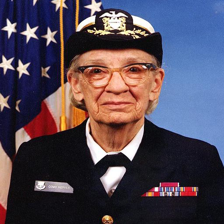

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### **Decode the predictions**

16384/10484 [==============================================] - 0s 0us/step


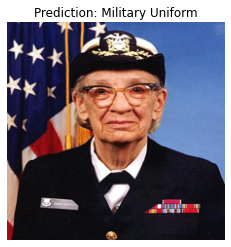

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# **Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset**

### **Dataset**

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMTM0BS/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [0]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['miniature poodle', 'tabby', 'Tibetan terrier', 'German shepherd',
       'Egyptian cat', 'Egyptian cat', 'tiger cat', 'Border collie',
       'golden retriever', 'Shih-Tzu', 'tabby', 'Persian cat', 'tabby',
       'Border collie', 'Egyptian cat', 'tabby', 'basset', 'puck',
       'Egyptian cat', 'Bouvier des Flandres', 'briard',
       'miniature pinscher', 'American Staffordshire terrier', 'tabby',
       'tiger cat', 'American Staffordshire terrier', 'Great Dane',
       'Egyptian cat', 'Chihuahua', 'miniature poodle', 'kelpie',
       'toy terrier'], dtype='<U30')

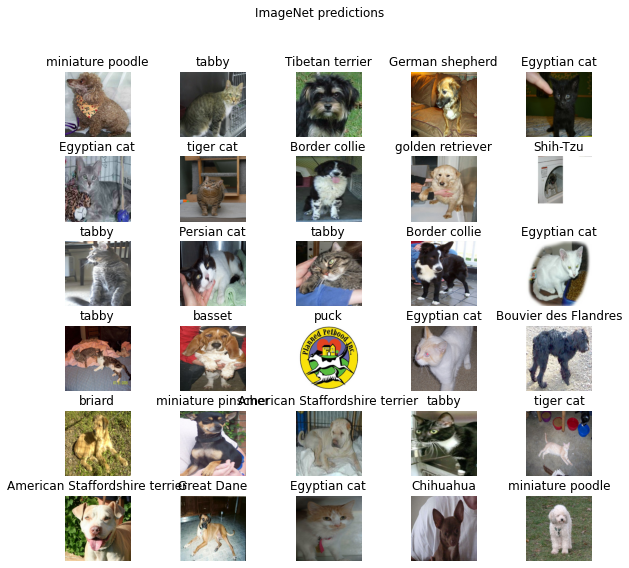

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# **Part 3: Do simple transfer learning with TensorFlow Hub**

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [16]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor.trainable = False

### **Attach a classification head**

In [18]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### **Train the model**

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 34s 58ms/step - loss: 0.0578 - accuracy: 0.9799 - val_loss: 0.0312 - val_accuracy: 0.9884
Epoch 2/6
582/582 [==============================] - 33s 56ms/step - loss: 0.0310 - accuracy: 0.9894 - val_loss: 0.0302 - val_accuracy: 0.9912
Epoch 3/6
582/582 [==============================] - 33s 56ms/step - loss: 0.0255 - accuracy: 0.9908 - val_loss: 0.0331 - val_accuracy: 0.9890
Epoch 4/6
582/582 [==============================] - 33s 56ms/step - loss: 0.0219 - accuracy: 0.9926 - val_loss: 0.0307 - val_accuracy: 0.9895
Epoch 5/6
582/582 [==============================] - 33s 56ms/step - loss: 0.0203 - accuracy: 0.9924 - val_loss: 0.0293 - val_accuracy: 0.9912
Epoch 6/6
582/582 [==============================] - 32s 55ms/step - loss: 0.0182 - accuracy: 0.9934 - val_loss: 0.0315 - val_accuracy: 0.9901


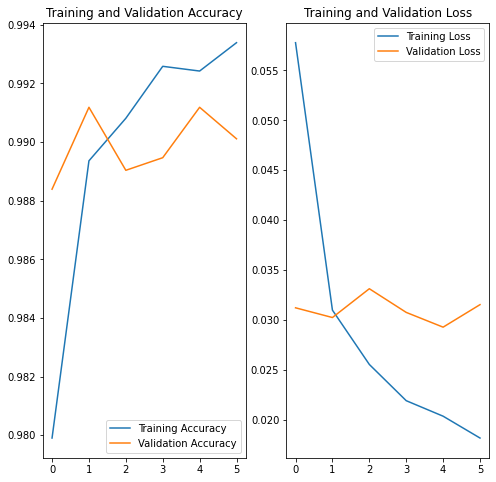

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()